Import libraries and Get Weather Station Info available from Met Eireann. 

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point

#Get Weather Stations details available from Met Eireann 
wsdf = pd.read_csv('https://cli.fusio.net/cli/climate_data/webdata/StationDetails.csv')
wsdf.head
print(wsdf.dtypes)

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year        object
close year       object
dtype: object


The Values in 'open year' and 'close year' are a combination of numeric text values and '(null)'
We want to analyse data from Weather Stations which have data from 2010 to the present
We'll convert the '(null)' to a future year '300' and convert to int.
This allows us to filter the data based on Year

In [2]:
#Convert Values in 'open year' and 'close year' from '(null)' to future year '3000'
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].replace(['(null)'], '3000')
#Change 'open year' and 'close year' to int
wsdf[['open year', 'close year']] = wsdf[['open year', 'close year']].astype(int)
print(wsdf.dtypes)
#Filter Weather Stations to those reporting data fdrom 2010 to the present
ltywsdf=wsdf.loc[(wsdf['close year'] == 3000) & (wsdf['open year'] < 2011)]
ltywsdf.head

county           object
station name      int64
name             object
height(m)         int64
easting           int64
northing          int64
latitude        float64
longitude       float64
open year         int32
close year        int32
dtype: object


<bound method NDFrame.head of        county  station name                             name  height(m)  \
0      Antrim          5880                  LH_RATHLIN_WEST         10   
1      Carlow          4415              TULLOW (Waterworks)         76   
10     Carlow          6114             POLLMOUNTY FISH FARM         24   
15     Carlow           375                         OAK PARK         62   
17     Carlow          4515           TULLOW (Ardoyne Glebe)         79   
...       ...           ...                              ...        ...   
2074  Wicklow          9420  M.GLENMALURE (Cloghernagh For.)        436   
2075  Wicklow          9520   M.RATHDRUM (Ballintombay For.)        384   
2078  Wicklow          9820                    M.LOUGH OULER        457   
2079  Wicklow          2415            GLEN IMAAL (For.Stn.)        213   
2080  Wicklow          2420              OLDBRIDGE (Oakview)        335   

      easting  northing  latitude  longitude  open year  close year  

Verify the stations have a satisfactory geographical distribution by plotting the latitude and longitude

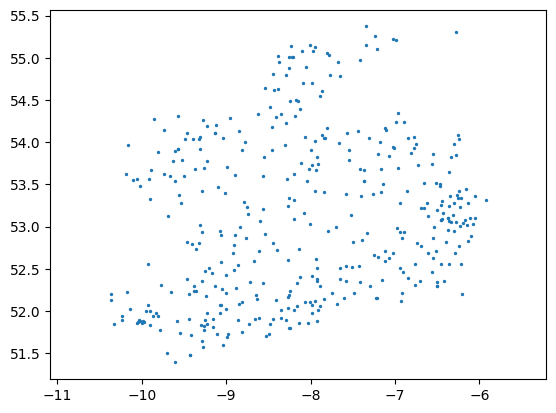

In [10]:
plt.scatter(x=ltywsdf['longitude'],y=ltywsdf['latitude'],s=2)
plt.axis('equal')

plt.show()


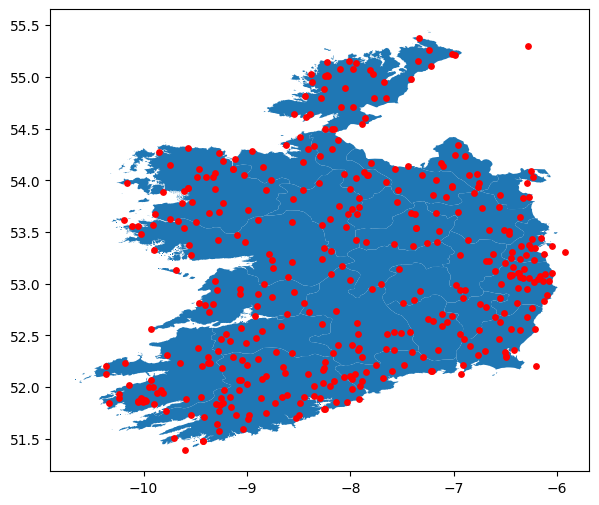

In [26]:
geometry = [Point(xy) for xy in zip(ltywsdf['longitude'], ltywsdf['latitude'])]
gdf = GeoDataFrame(ltywsdf, geometry=geometry) 

IRL_map= gpd.read_file('./IRL_adm/IRL_adm1.shp')  #reading the map 
gdf.plot(ax=IRL_map.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);